___

# Preço médio de casas de uma região

### ALUNOS: Enzo Quental, João Pedro Rodrigues, João Pedro Natal, João Pedro Fiorin.
### 2A

In [1]:
%matplotlib inline
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from math import *
from scipy.stats import norm, probplot
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor as dt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from IPython.display import display

pd.set_option("display.max_colwidth", None)

In [2]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\jprfi\OneDrive\Área de Trabalho\CDADOS


In [3]:
# Função utilitária para fazer a regressão com constante adicionada

def regress(Y,X):
    '''
    Y: coluna do DataFrame utilizada como variável resposta (TARGET)
    X: coluna(s) do DataFrame utilizadas como variável(is) explicativas (FEATURES)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    
    return results

In [4]:
data = pd.read_csv("housing.csv")

In [5]:
data.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
# Analisando se em alguma variável temos a presença de valores nulos ou nan.
data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [7]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [8]:
# Retirando os valores nulos da variável total_bedrooms.
filtra_linhas_0 = data['total_bedrooms'] != 0
datan = data.loc[filtra_linhas_0, :]
datan = datan.dropna()
df = datan[['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 
            'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']]

In [9]:
# Analisando novamente para confirmar que a remoção funcionou.
datan.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [10]:
# Features quantitativas:
X = df[['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'population', 'households', 'total_bedrooms', 'median_income', 'ocean_proximity']]

# Target a ser estudado: 
Y = df['median_house_value']

In [11]:
datan.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [12]:
# Transformando a variável ocean proximity em quantitativa.
X = pd.get_dummies(X)
X = X.dropna()
X

,longitude,latitude,housing_median_age,total_rooms,population,households,total_bedrooms,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,322.0,126.0,129.0,8.3252,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,2401.0,1138.0,1106.0,8.3014,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,496.0,177.0,190.0,7.2574,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,558.0,219.0,235.0,5.6431,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,565.0,259.0,280.0,3.8462,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,845.0,330.0,374.0,1.5603,0,1,0,0,0
20636,-121.21,39.49,18.0,697.0,356.0,114.0,150.0,2.5568,0,1,0,0,0
20637,-121.22,39.43,17.0,2254.0,1007.0,433.0,485.0,1.7000,0,1,0,0,0
20638,-121.32,39.43,18.0,1860.0,741.0,349.0,409.0,1.8672,0,1,0,0,0


___
## Análise exploratória das variáveis.

Na parte de analise exploratória nós iremos estudar as nossas variáveis do dataset através de tabelas, gráficos e etc...

___
* Mostrando, através de um pairplot, as relações entre as variáveis do nosso dataset
* Quanto mais linear for o gráfico de relação, mais essas duas variáveis se relacionam, se influenciam.

<IPython.core.display.Javascript object>


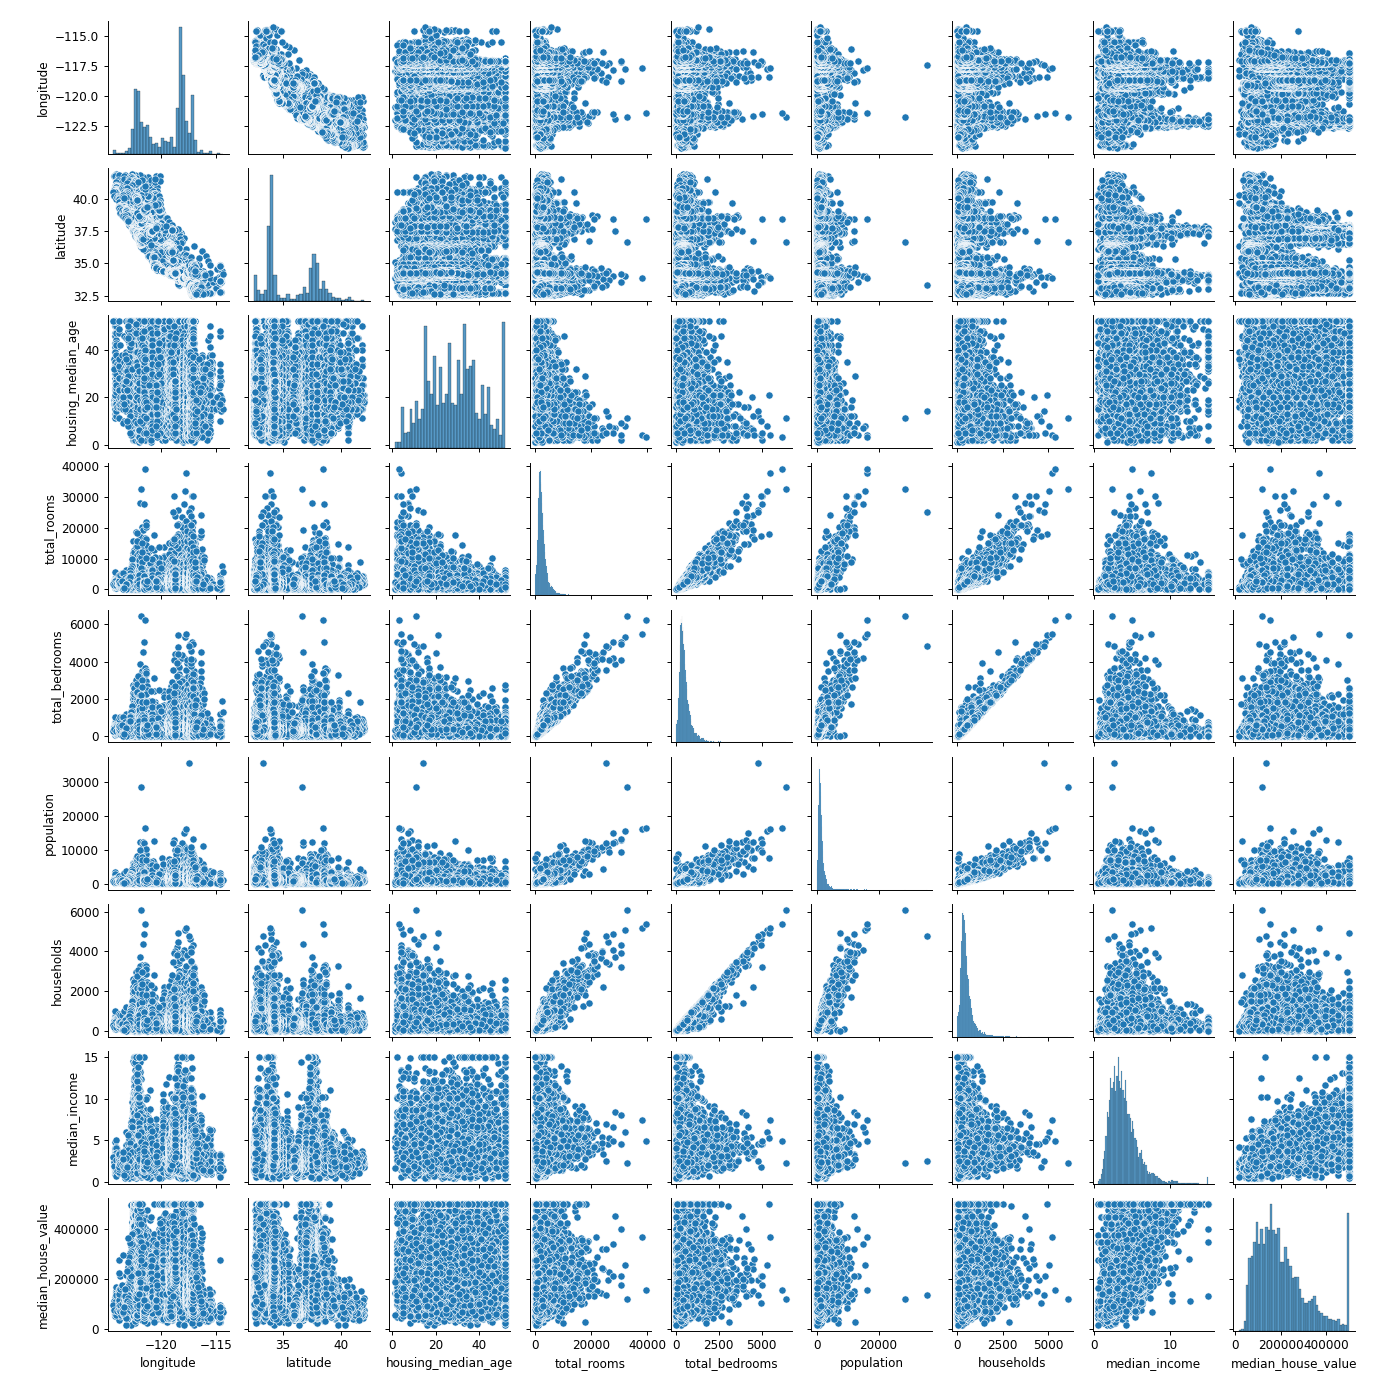

In [13]:
sns.pairplot(df, height=1.5);

___

* Com o uso do regress, nós vamos plotar uma tabela que nos mostre informações que as features possuem em relação ao nosso target. 
* Na coluna $P > |t|$, da tabela abaixo, quanto mais próximo de 0 o valor resultar, mais essa variável influencia no target, no nosso caso, o preço da casa. 

In [14]:
results = regress(Y,X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_house_value   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     3112.
Date:                Tue, 30 Nov 2021   Prob (F-statistic):               0.00
Time:                        09:59:56   Log-Likelihood:            -2.5655e+05
No. Observations:               20433   AIC:                         5.131e+05
Df Residuals:                   20420   BIC:                         5.132e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                      -1.873e+06   7.36e+04    -25.441      0.000   -2.02e+06   -1.73e+06
longitude                  -2.681e+04   1019.651    -26.296      0.000   -2.88e+04   -2.48e+04
latitude                   -2.548e+04   1004.702    -25.363      0.000   -2.75e+04   -2.35e+04
housing_median_age          1072.5200     43.886     24.439      0.000     986.501    1158.540
total_rooms                   -6.1933      0.791     -7.825      0.000      -7.745      -4.642
population                   -37.9691      1.076    -35.282      0.000     -40.078     -35.860
households                    49.6173      7.451      6.659      0.000      35.012      64.222
total_bedrooms               100.5563      6.869     14.640      0.000      87.093     114.019
median_income               3.926e+04    338.005    116.151      0.000    3.86e+04    3.99e+04
ocean_proximity_<1H OCEAN  -3.973e+05   1.55e+04    -25.676      0.000   -4.28e+05   -3.67e+05
ocean_proximity_INLAND     -4.366e+05   1.45e+04    -30.054      0.000   -4.65e+05   -4.08e+05
ocean_proximity_ISLAND     -2.444e+05   2.99e+04     -8.187      0.000   -3.03e+05   -1.86e+05
ocean_proximity_NEAR BAY   -4.013e+05   1.59e+04    -25.197      0.000   -4.32e+05    -3.7e+05
ocean_proximity_NEAR OCEAN  -3.93e+05   1.58e+04    -24.835      0.000   -4.24e+05   -3.62e+05
==============================================================================
Omnibus:                     5049.292   Durbin-Watson:                   0.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19123.138
Skew:                           1.197   Prob(JB):                         0.00
Kurtosis:                       7.090   Cond. No.                     2.68e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.43e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

___
* Antes de fazer análise em Bloxplot, vamos ver como as variáveis são distribuídas em histogramas.  

<IPython.core.display.Javascript object>


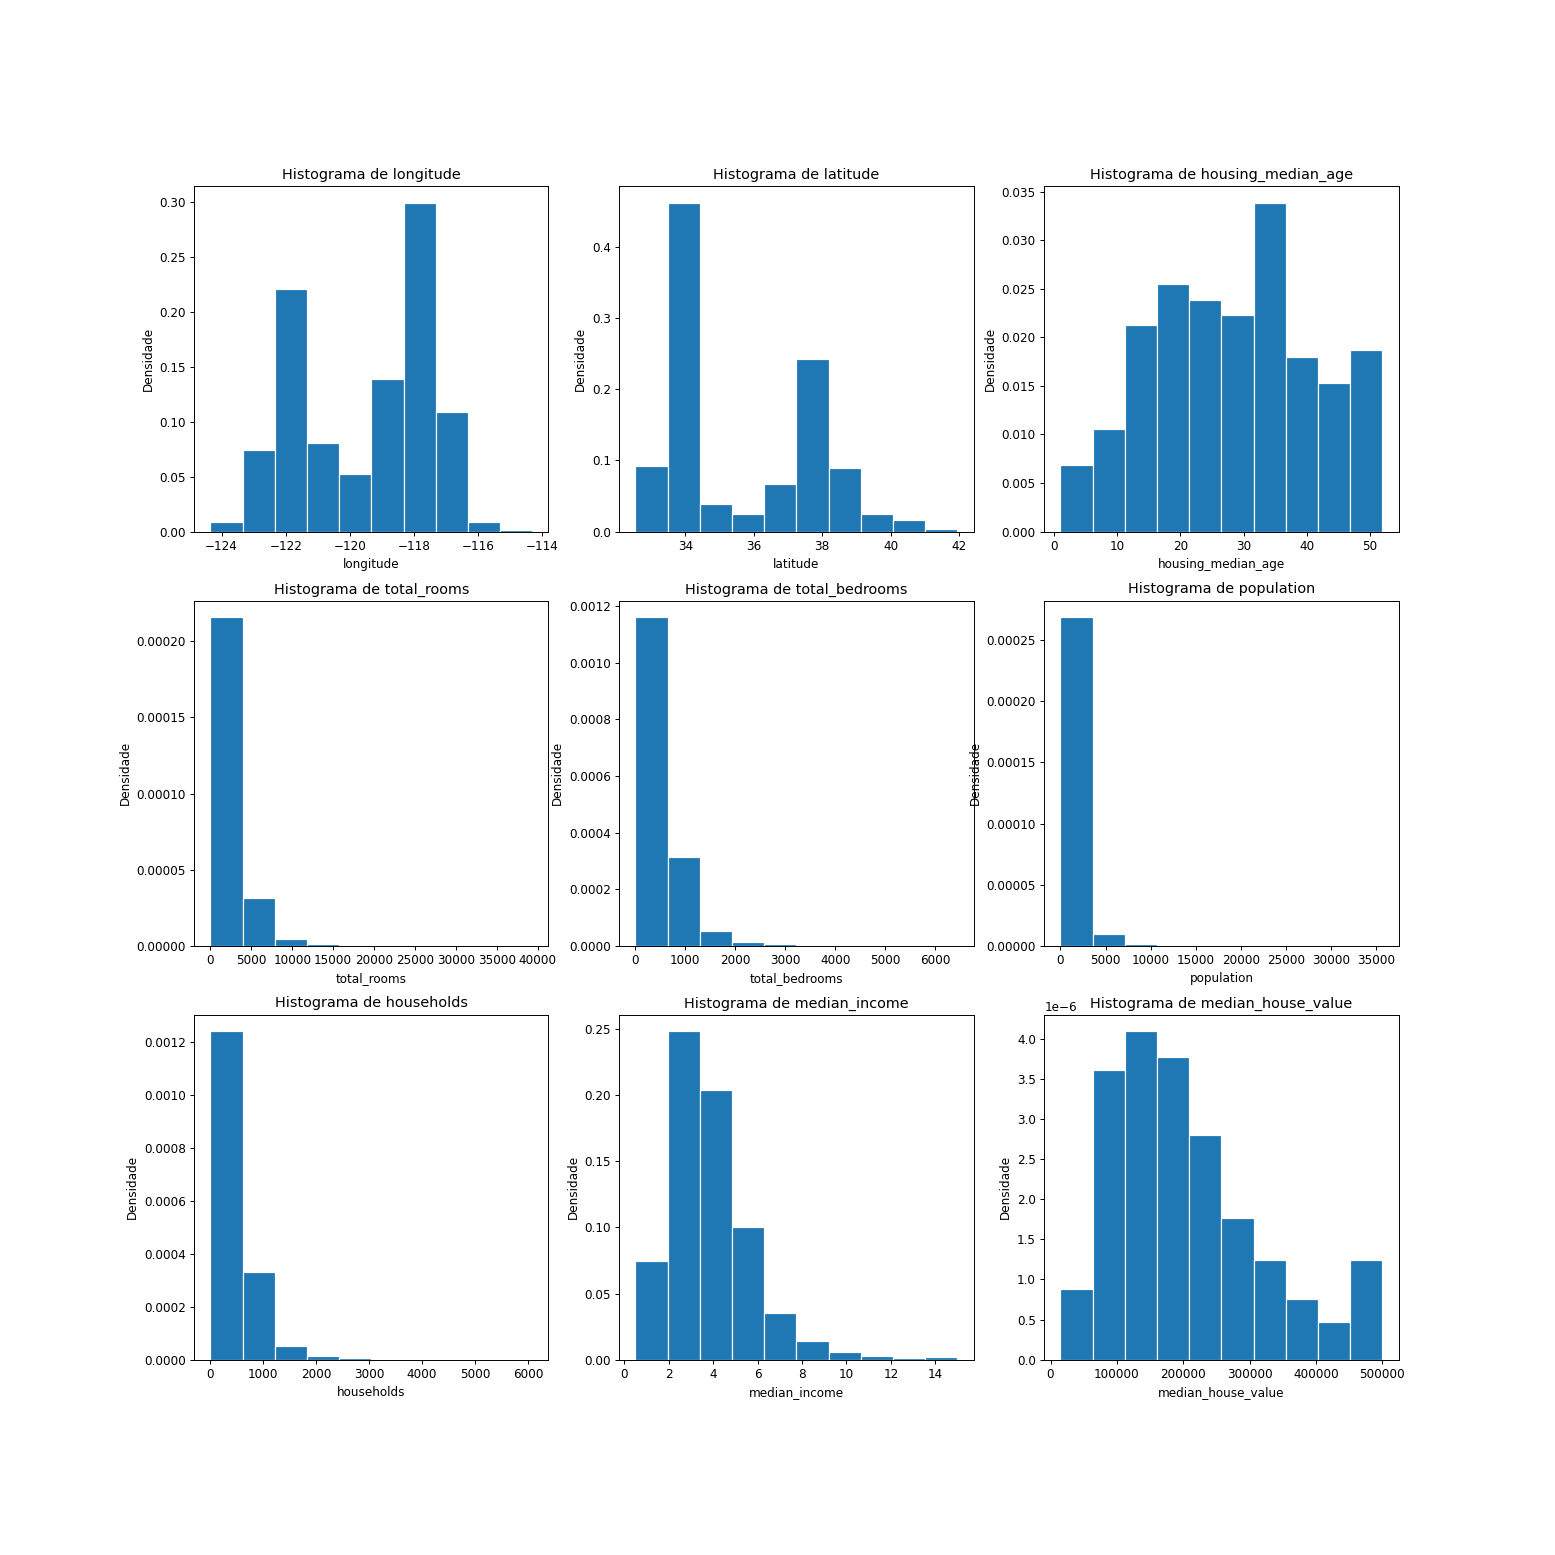

In [15]:
plt.figure(figsize = (18,18))
plt.subplot(331)
plt.hist(df['longitude'], edgecolor = 'white', density = True)
plt.title('Histograma de longitude')
plt.xlabel('longitude')
plt.ylabel('Densidade')
plt.show()

plt.subplot(332)
plt.hist(df['latitude'], edgecolor = 'white', density = True)
plt.title('Histograma de latitude')
plt.xlabel('latitude')
plt.ylabel('Densidade')
plt.show()

plt.subplot(333)
plt.hist(df['housing_median_age'], edgecolor = 'white', density = True)
plt.title('Histograma de housing_median_age')
plt.xlabel('housing_median_age')
plt.ylabel('Densidade')
plt.show()

plt.subplot(334)
plt.hist(df['total_rooms'], edgecolor = 'white', density = True)
plt.title('Histograma de total_rooms')
plt.xlabel('total_rooms')
plt.ylabel('Densidade')
plt.show()

plt.subplot(335)
plt.hist(df['total_bedrooms'], edgecolor = 'white', density = True)
plt.title('Histograma de total_bedrooms')
plt.xlabel('total_bedrooms')
plt.ylabel('Densidade')
plt.show()

plt.subplot(336)
plt.hist(df['population'], edgecolor = 'white', density = True)
plt.title('Histograma de population')
plt.xlabel('population')
plt.ylabel('Densidade')
plt.show()

plt.subplot(337)
plt.hist(df['households'], edgecolor = 'white', density = True)
plt.title('Histograma de households')
plt.xlabel('households')
plt.ylabel('Densidade')
plt.show()

plt.subplot(338)
plt.hist(df['median_income'], edgecolor = 'white', density = True)
plt.title('Histograma de median_income')
plt.xlabel('median_income')
plt.ylabel('Densidade')
plt.show()

plt.subplot(339)
plt.hist(df['median_house_value'], edgecolor = 'white', density = True)
plt.title('Histograma de median_house_value')
plt.xlabel('median_house_value')
plt.ylabel('Densidade')
plt.show()

___
* Nesta análise nós vamos usar o gráfico de caixa, ou Boxplot. Ele pode ser confirmado através do estudo que fizemos acima com os histogramas.
* O Grafico de caixa nos mostra os valores de máximo e mínimo, o primeiro e terceiro quartil, a mediana e os outliers da variável. 
* *Outliers são os valores que fogem da normalidade dos outros podendo causar anomalias nos resultados de média e entre outros. 

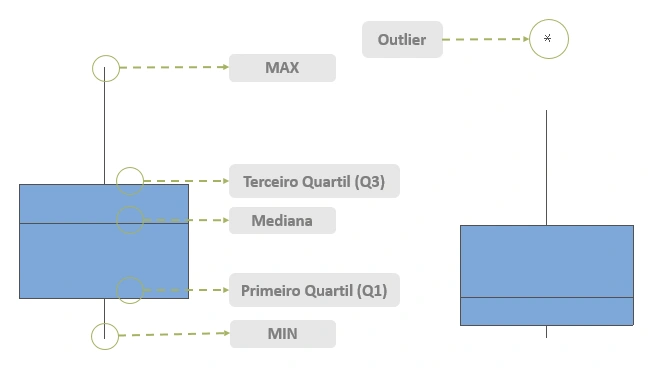

<IPython.core.display.Javascript object>


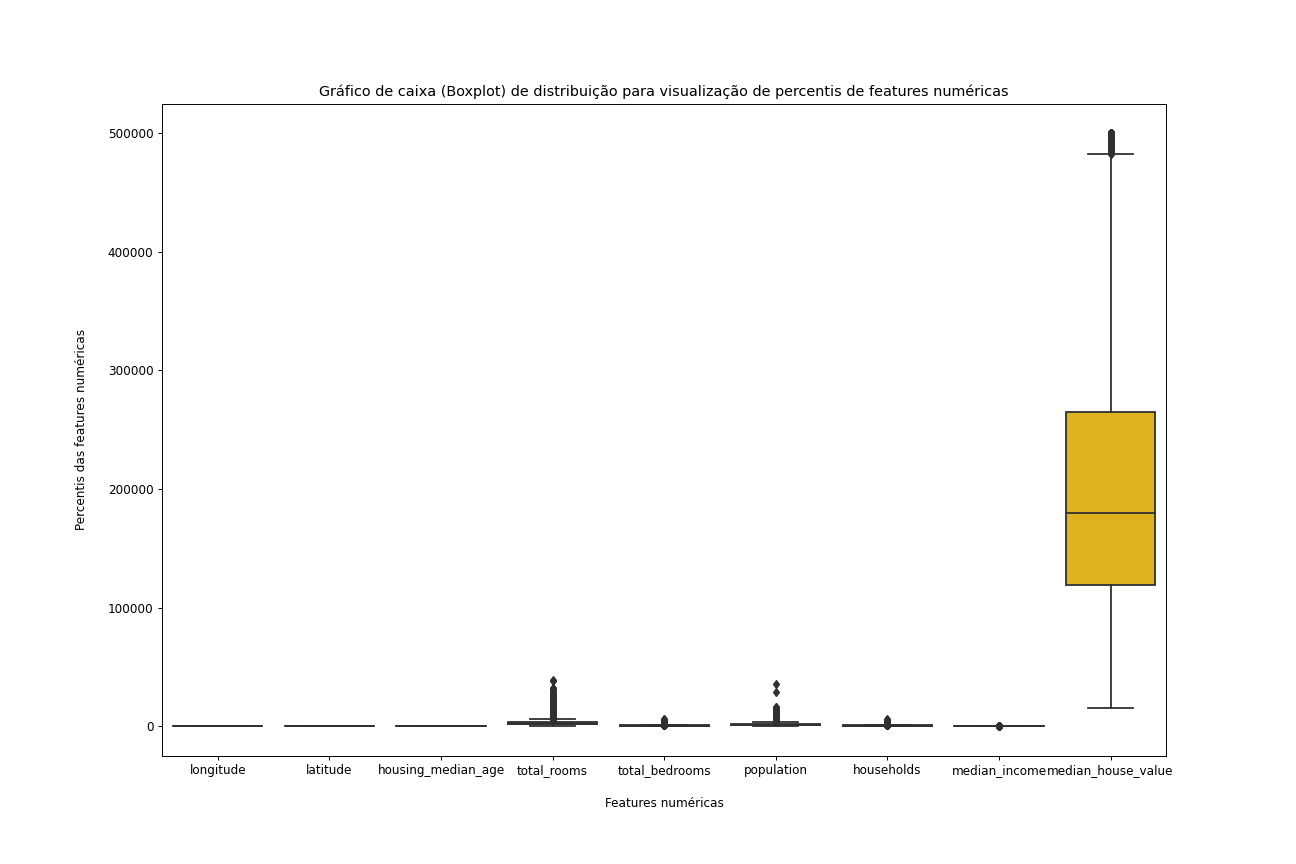

In [16]:
# Plotando o boxplot para uma visualização dos percentis das features numéricas.
plt.figure(figsize=(15, 10))
sns.boxplot(data=df, palette='bright')
plt.title('Gráfico de caixa (Boxplot) de distribuição para visualização de percentis de features numéricas')
plt.xlabel('\nFeatures numéricas')
plt.ylabel('Percentis das features numéricas\n')
plt.show()

* Como nós podemos perceber no gráfico acima, a variável median_house_value possui valores mais altos do que as outras variáveis, deixando-as quase imperceptíveis. 
* Para resolver isso, vamos plotar um Bloxplot retirando a variável median_house_values. 

<IPython.core.display.Javascript object>


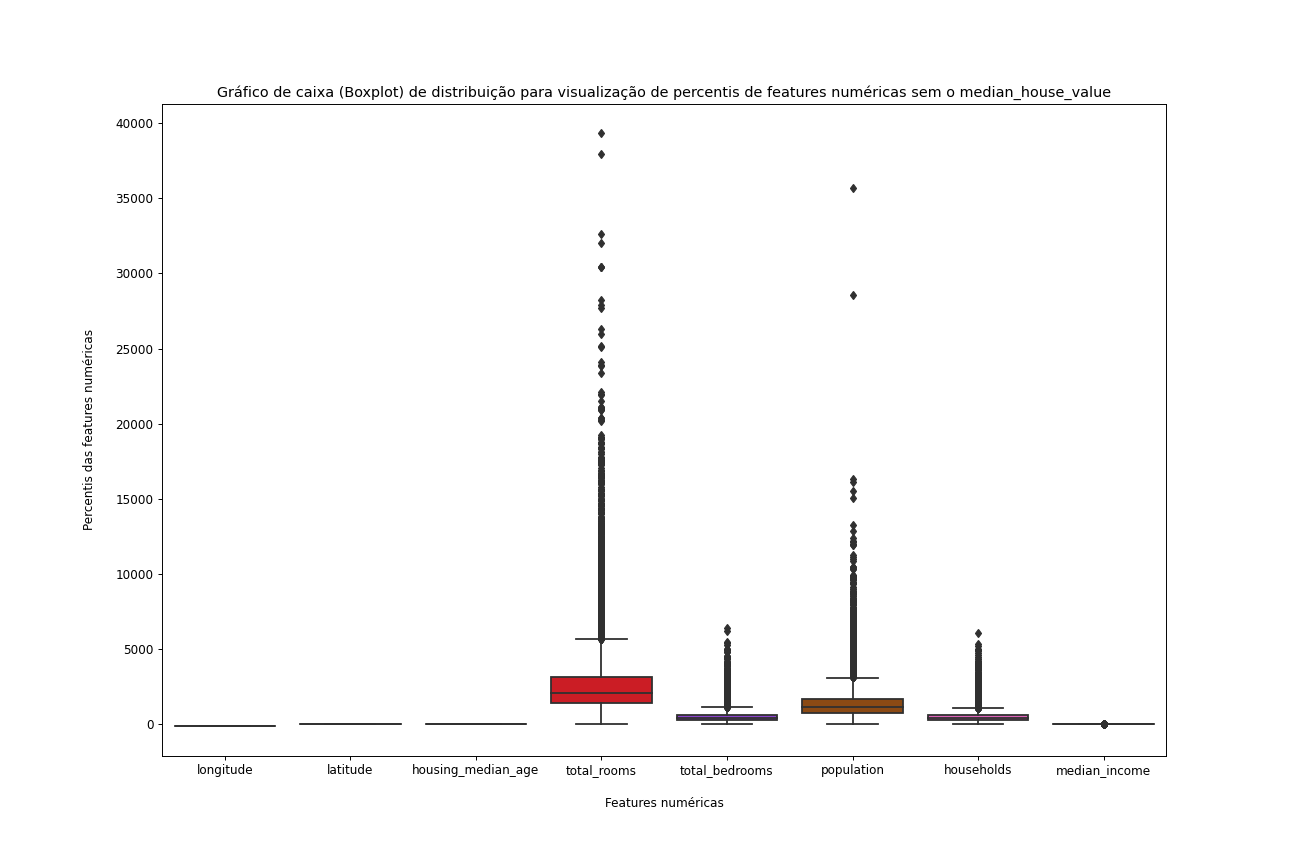

In [17]:
df_boxplot = datan[['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 
            'population', 'households', 'median_income']]
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_boxplot, palette='bright')
plt.title('Gráfico de caixa (Boxplot) de distribuição para visualização de percentis de features numéricas sem o median_house_value')
plt.xlabel('\nFeatures numéricas')
plt.ylabel('Percentis das features numéricas\n')
plt.show()

* Um ponto interessante a notar nesse gráfico é que nas variáveis longitude e latitude os valores são muito próximos que não chega a criar uma box. Isso ocorre porque estamos pegando informaçãoes de uma mesma região, ou seja, quase a mesma, com muita pouca variação, longitude e latitude.

___ 
* Passando para outro ferramental de análise, nós iremos usar um heatmap. Nele calculamos a correlação entre as variáveis. 
* A correlção é um número entre 1 e -1 que nos mostra quanto uma variável se correlaciona com a outra. Para números mais perto de 1, maior é a correlação, já para números mais perto de -1, o contrário. 

<IPython.core.display.Javascript object>


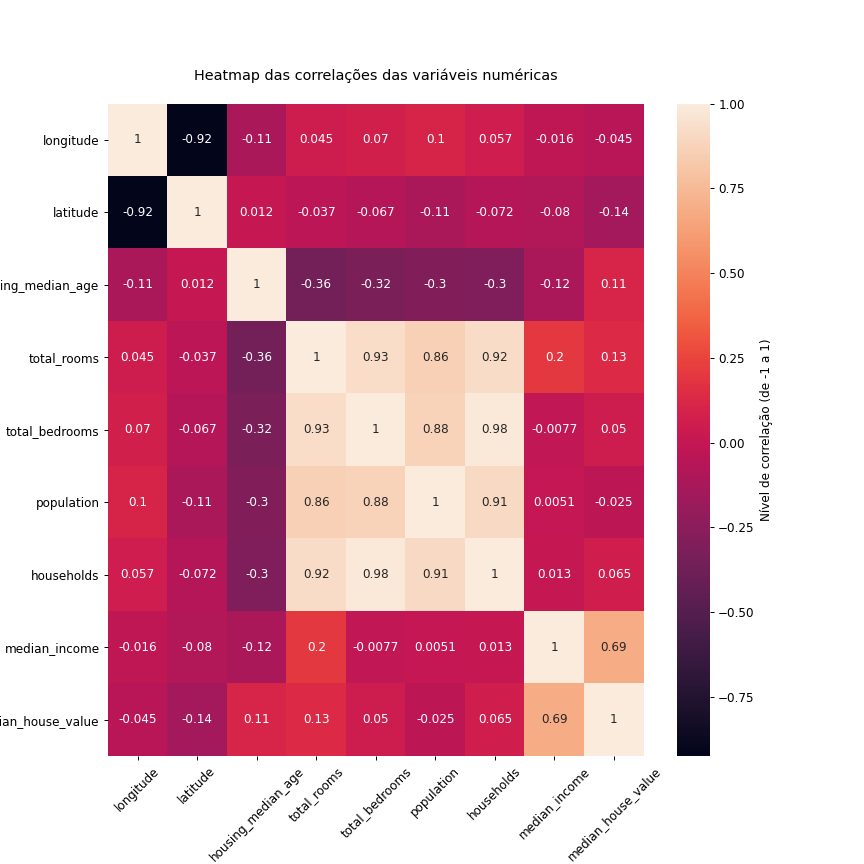

In [18]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, cbar_kws={'label': 'Nível de correlação (de -1 a 1)'})
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Heatmap das correlações das variáveis numéricas\n')
plt.show()

___
## Modelos preditivos

Para realizar as predições, decidimos utilizar a regressão que é um método que tem como objetivo determinar quais variáveis independentes possuem um impacto em uma variável dependente. Nesse projeto, vamos utilizar 3 tipos de regressão:

* Decision Tree Regressor
* Random Forest Regression
* Ainda não sabemos

In [19]:
# Definindo algumas variáveis que usaremos nos modelos:
labels = np.array(datan['median_house_value'])
datan = datan.drop('median_house_value', axis = 1)

train_data, test_data, train_labels, test_labels = train_test_split(datan, labels, test_size = 0.3, random_state = 42)

train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

## Modelo Decision Tree Regressor

In [20]:
regressor = dt(random_state=42)
cross_val_dt = cross_val_score(regressor, train_data, train_labels, cv=10)
fit_dt = regressor.fit(train_data,train_labels)
predictions_dt = regressor.predict(test_data)

In [36]:
score = r2_score(test_labels, predictions_dt)
mae = mean_absolute_error(test_labels, predictions_dt)
rmse = mean_squared_error(test_labels, predictions_dt,squared=False)
tabela = {'Valores' :{
    'R² score' : score,
    'Root mean squared error' : rmse,
    'Mean absolute error' : mae
    }
}
display(pd.DataFrame(tabela))

,Valores
Mean absolute error,42163.662643
Root mean squared error,66714.884998
R² score,0.666124


### Resíduos do modelo: 
   * Os resíduos são calculados pela diferença entre o valor real menos o valor previsto pelo modelo. 
   * Quanto mais perto de zero esse valor resulta, mais eficiente foram as previsões do modelo. 

In [21]:
residuos_dt = test_labels - predictions_dt
pd.Series(residuos_dt).describe()

count      6130.000000
mean       1368.162153
std       66706.295854
min     -419401.000000
25%      -23275.000000
50%           0.000000
75%       25000.000000
max      387501.000000
dtype: float64

<IPython.core.display.Javascript object>


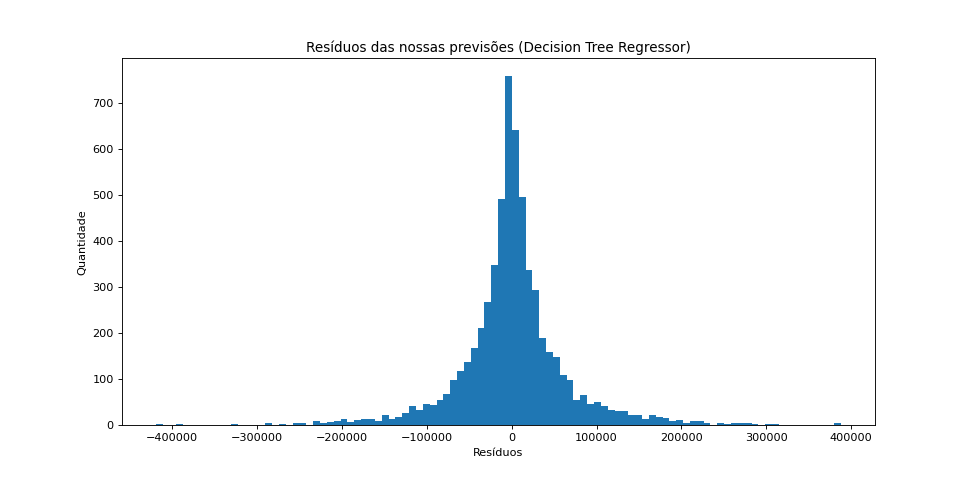

In [40]:
plt.figure(figsize=(12,6))
plt.hist(residuos_dt, bins=100)
plt.title('Resíduos das nossas previsões (Decision Tree Regressor)')
plt.xlabel('Resíduos')
plt.ylabel('Quantidade')
plt.show()

* Através da analise do gráfico, podemos concluir que nosso modelo previu bem os valores das casas. 

## Modelo Random Forest Regression

In [26]:
# Criando modelo
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42, n_jobs = -1)
rf.fit(train_data, train_labels)

# Criando previsões
predictions_rf = rf.predict(test_data)

In [34]:
score = r2_score(test_labels, predictions_rf)
mae = mean_absolute_error(test_labels, predictions_rf)
rmse = mean_squared_error(test_labels, predictions_rf,squared=False)
tabela = {'Valores' :{
    'R² score' : score,
    'Root mean squared error' : rmse,
    'Mean absolute error' : mae
    }
}
display(pd.DataFrame(tabela))

,Valores
Mean absolute error,31414.383596
Root mean squared error,48468.728634
R² score,0.823777


### Resíduos do modelo: 

In [28]:
residuos_rf = test_labels - predictions_rf
pd.Series(residuos_rf).describe()

count      6130.000000
mean        423.319386
std       48470.833728
min     -312977.634000
25%      -21846.775250
50%       -4368.721500
75%       15484.125000
max      356330.700000
dtype: float64

<IPython.core.display.Javascript object>


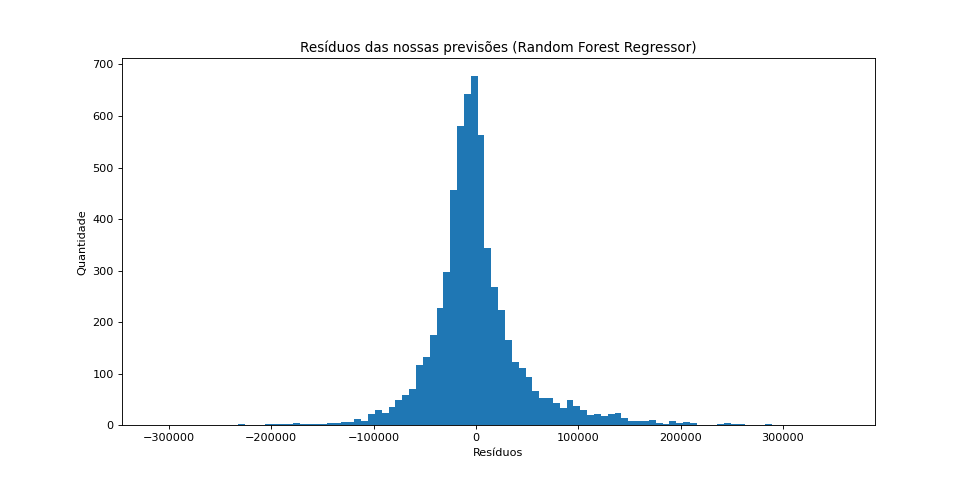

In [39]:
plt.figure(figsize=(12,6))
plt.hist(residuos_rf, bins=100)
plt.title('Resíduos das nossas previsões (Random Forest Regressor)')
plt.xlabel('Resíduos')
plt.ylabel('Quantidade')
plt.show()